## Markdown to check number of features based on PCA

In [1]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

CLIP_FEATURES_DIR = "clip_features"
TRAIN = CLIP_FEATURES_DIR + "/train_features.pt"
VAL = CLIP_FEATURES_DIR + "/val_features.pt"
VARIANCE = 0.95

In [2]:
def load_features(file_path):
    data = torch.load(file_path)
    return data["image_features"], data["text_features"], data["filenames"], data["labels"]


# Load train and validation features
train_img_features, train_txt_features, _, train_labels = load_features(TRAIN)
val_img_features, val_txt_features, _, val_labels = load_features(VAL)

In [3]:
# Combine image and text features for training
X_train = torch.cat((train_img_features, train_txt_features), dim=1)
X_val = torch.cat((val_img_features, val_txt_features), dim=1)

# Flatten features into a 2D matrix (samples x features)
X_train = X_train.view(X_train.size(0), -1).numpy()
X_val = X_val.view(X_val.size(0), -1).numpy()

# Convert labels to NumPy arrays
y_train = train_labels.numpy()
y_val = val_labels.numpy()     

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Apply PCA to the features
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

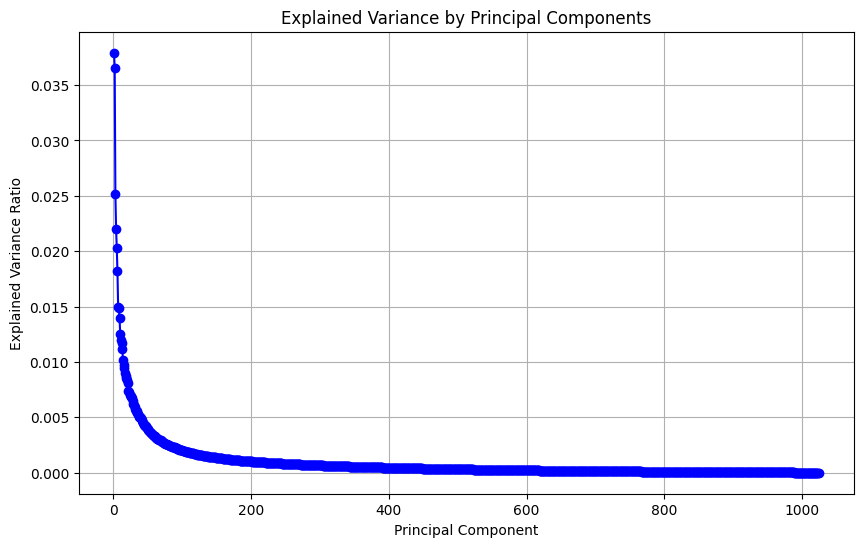

In [4]:
# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

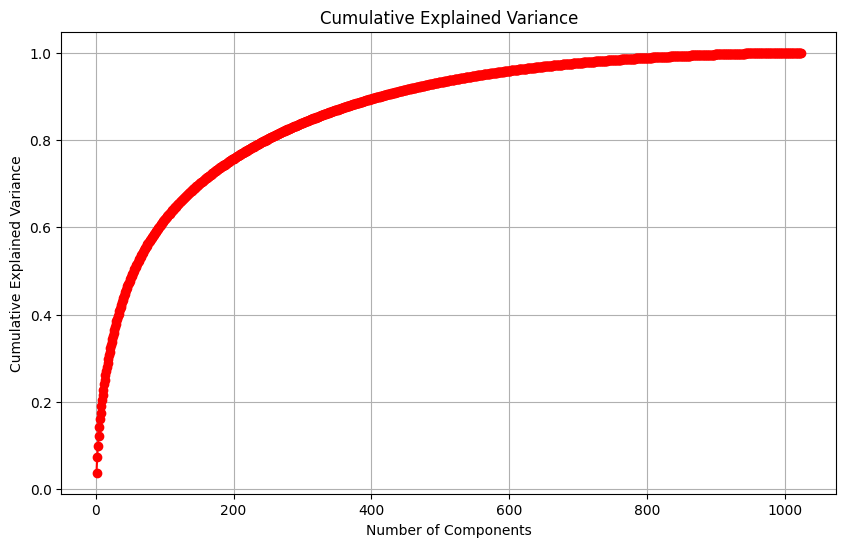

In [5]:
cumulative_explained_variance = explained_variance.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [6]:
n_components_95 = (cumulative_explained_variance >= VARIANCE).argmax() + 1  # +1 because index is 0-based

print(f"Number of components that explain at least 95% of the variance: {n_components_95}")

# Apply PCA with the selected number of components
pca_95 = PCA(n_components=n_components_95)


Number of components that explain at least 95% of the variance: 563


In [7]:
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_val_pca_95 = pca_95.transform(X_val_scaled)

## Train SVM

In [8]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train_pca_95, y_train)  # Example: Replace with actual labels

# Make predictions on the validation set
y_pred = svm.predict(X_val_pca_95)


# Evaluate the SVM
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {accuracy:.4f}")

# Save the trained SVM model to disk
joblib.dump(svm, 'svm_model.joblib')
joblib.dump(scaler, 'scaler_model.joblib')  # Save the scaler too for future use

# Save the PCA model as well (for later use in transforming new data)
joblib.dump(pca_95, 'pca_model.joblib')

Validation accuracy: 0.6237


['pca_model.joblib']